In [1]:
import snapatac2 as snap

## preprocessing

In [3]:
fragment_file = "/jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/mapeiyao/02.scATAC_pipeline/00.data/02.c4/human_pbmc_c4/20220808-ATAC-E-B21564294836-a-1/20220808-ATAC-E-B21564294836-a-1.fragments.tsv.gz"

In [4]:
gff_file="/jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/mapeiyao/GRCH38/gencode.v41.basic.annotation.gff3.gz"
import pandas as pd


In [5]:
chrom_size=pd.read_csv("/jdfssz1/ST_SUPERCELLS/PUB/snATAC/pipeline/01.scATAC_v3.0/bin/d2c_v1.4.4/bin/anno/bedtools/chrom_hg38.sizes",sep="\t",header = None)

In [6]:
tmp = list(zip(list(chrom_size[0]),list(chrom_size[1])))

In [7]:
chrom_size_dict = dict(tmp)

In [8]:
chrom_size_dict

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr10': 133797422,
 'chr11': 135086622,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr19': 58617616,
 'chr20': 64444167,
 'chr21': 46709983,
 'chr22': 50818468,
 'chrX': 156040895,
 'chrM': 16571,
 'chrY': 57227415}

In [9]:
data = snap.pp.import_data(
    fragment_file,
    gff_file = gff_file,
    chrom_size = chrom_size_dict,
    file="pbmc.h5ad",
    sorted_by_barcode=False,
)
data

AnnData object with n_obs x n_vars = 7816 x 0 backed at 'pbmc.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito
    uns: reference_sequences
    obsm: insertion

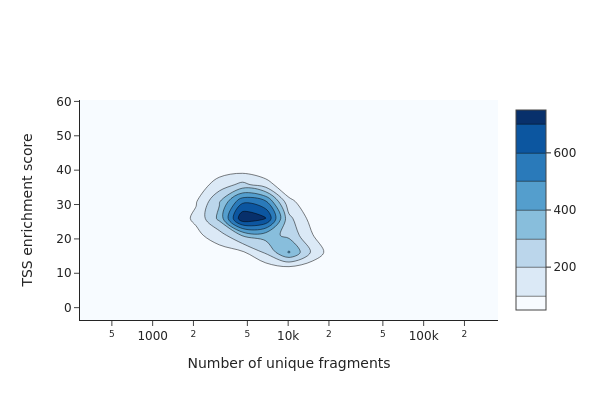

In [10]:
snap.pl.tsse(data, interactive=False)


In [11]:
snap.pp.filter_cells(data, min_counts=2000, min_tsse=10, max_counts=50000)
data

AnnData object with n_obs x n_vars = 7082 x 0 backed at 'pbmc.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito
    uns: reference_sequences
    obsm: insertion

In [12]:
import time

start = time.time()
snap.pp.add_tile_matrix(data)
end = time.time()
print(end-start)

60.73703169822693


In [13]:
data

AnnData object with n_obs x n_vars = 7082 x 6176584 backed at 'pbmc.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito
    var: Feature_ID
    uns: reference_sequences
    obsm: insertion

In [15]:
help(snap.pp.add_tile_matrix)

Help on function add_tile_matrix in module snapatac2.preprocessing._basic:

add_tile_matrix(adata: 'AnnData', bin_size: 'int' = 500, chunk_size: 'int' = 500, n_jobs: 'int' = 4) -> 'None'
    Generate cell by bin count matrix.
    
    This function is used to generate and add a cell by bin count matrix to the AnnData
    object.
    
    :func:`~snapatac2.pp.import_data` must be ran first in order to use this function.
    
    Parameters
    ----------
    adata
        The (annotated) data matrix of shape `n_obs` x `n_vars`.
        Rows correspond to cells and columns to regions.
    bin_size
        The size of consecutive genomic regions used to record the counts.
    chunk_size
        Increasing the chunk_size speeds up I/O but uses more memory.
    n_jobs
        number of CPUs to use.



In [14]:
start = time.time()
snap.pp.select_features(data)
end = time.time()
print(end-start)

23.255120754241943


### remove doublet using scrublet

In [15]:
start = time.time()
snap.pp.scrublet(data)
end = time.time()
print(end-start)

2022-11-22 10:28:47 - INFO - Simulating doublets...
2022-11-22 10:28:48 - INFO - Spectral embedding ...
2022-11-22 10:30:54 - INFO - Calculating doublet scores...


456.79134249687195


In [17]:
start = time.time()
snap.pp.call_doublets(data)
snap.pl.scrublet(data, interactive=False)
end = time.time()
print(end-start)

43.918941020965576


In [19]:
data

AnnData object with n_obs x n_vars = 7082 x 6176584 backed at 'pbmc.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito, doublet_score, is_doublet
    var: Feature_ID, selected
    uns: reference_sequences, scrublet_threshold, scrublet_sim_doublet_score
    obsm: insertion

In [20]:
data.obs[:]

Cell,tsse,n_fragment,frac_dup,frac_mito,doublet_score,is_doublet
str,f64,u64,f64,f64,f64,bool
"""20220808-ATAC-...",24.44824,44838,0.0,0.2159,0.126984,false
"""20220808-ATAC-...",29.205742,23722,0.0,0.371935,0.158106,false
"""20220808-ATAC-...",24.989229,47828,0.0,0.139475,0.12008,false
"""20220808-ATAC-...",29.479907,49422,0.0,0.159518,0.216619,false
"""20220808-ATAC-...",10.418567,32358,0.0,0.076647,0.113829,false
"""20220808-ATAC-...",29.96932,27549,0.0,0.180187,0.23813,true
"""20220808-ATAC-...",30.298099,28668,0.0,0.139332,0.562499,true
"""20220808-ATAC-...",26.446281,28970,0.0,0.259003,0.336514,true
"""20220808-ATAC-...",29.458414,23176,0.0,0.268919,0.169733,false


In [29]:
data.close()

In [30]:
# import scanpy as scp
# data = scp.read("pbmc.h5ad")

In [35]:
data = snap.read("pbmc.h5ad")

In [37]:
type(data)

AnnData

In [38]:
data

AnnData object with n_obs x n_vars = 7082 x 6176584 backed at 'pbmc.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito, doublet_score, is_doublet
    var: Feature_ID, selected
    uns: reference_sequences, scrublet_sim_doublet_score, scrublet_threshold
    obsm: insertion

In [41]:
# write into h5ad 
data.subset(~data.obs["is_doublet"])
data

# To subset an in-memory AnnData object, use: 
# singlet_data = data[~data.obs["is_doublet"], :]
# data.close()

AnnData object with n_obs x n_vars = 6852 x 6176584 backed at 'pbmc.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito, doublet_score, is_doublet
    var: Feature_ID, selected
    uns: reference_sequences, scrublet_sim_doublet_score, scrublet_threshold
    obsm: insertion

## Dimenstion reduction

In [42]:
start = time.time()
snap.tl.spectral(data)
end = time.time()
print(end-start)

2022-11-22 13:32:17 - INFO - Compute similarity matrix
2022-11-22 13:32:24 - INFO - Normalization
2022-11-22 13:32:28 - INFO - Perform decomposition


75.70747470855713


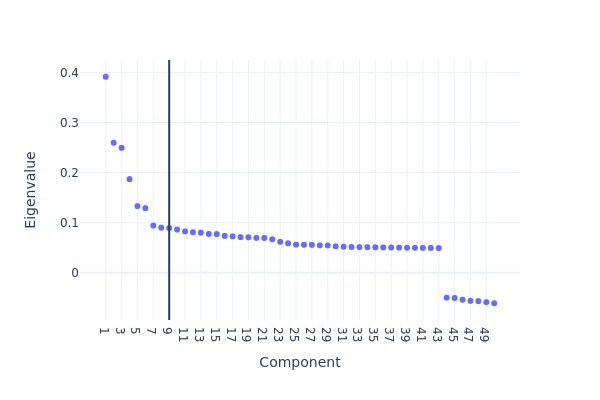

In [44]:
snap.pl.spectral_eigenvalues(data, interactive=False)

In [46]:
start = time.time()
snap.tl.umap(data, use_dims=10)
end = time.time()
print(end-start)

66.29992485046387


### clustering

In [47]:
start = time.time()
snap.pp.knn(data, use_dims=10)
snap.tl.leiden(data)
end = time.time()
print(end-start)

5.412716627120972


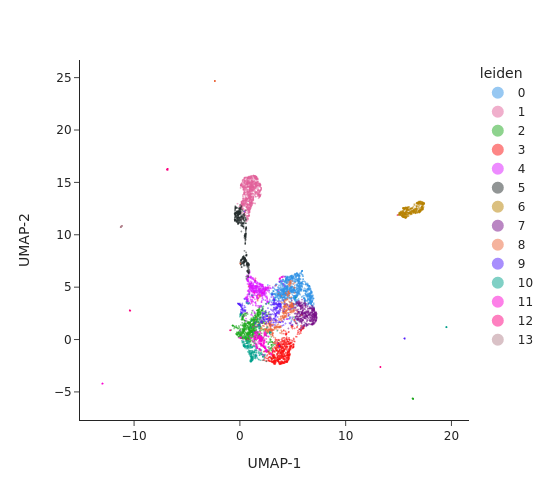

In [48]:
snap.pl.umap(data, color="leiden", interactive=False)


## Create the cell by gene activity matrix

In [32]:
help(snap.pp.make_gene_matrix)

Help on function make_gene_matrix in module snapatac2.preprocessing._basic:

make_gene_matrix(adata: 'AnnData | AnnDataSet', gff_file: 'Genome | Path', file: 'Path', chunk_size: 'int' = 500, use_x: 'bool' = False, id_type: "Literal['gene', 'transcript']" = 'gene') -> 'AnnData'
    Generate cell by gene activity matrix.
    
    Generate cell by gene activity matrix by counting the TN5 insertions in gene
    body regions. The result will be stored in a new file and a new AnnData object
    will be created.
    
    Parameters
    ----------
    adata
        The (annotated) data matrix of shape `n_obs` x `n_vars`.
        Rows correspond to cells and columns to regions.
    gff_file
        Either a Genome object or the path of a gene annotation file in GFF format.
    file
        File name of the h5ad file used to store the result.
    use_x
        If True, use the matrix stored in `.X` to compute the gene activity.
        Otherwise the `.obsm['insertion']` is used.
    id_type
    

In [50]:
start = time.time()
gene_matrix = snap.pp.make_gene_matrix(data, gff_file = gff_file,file = "GCM.h5ad")
gene_matrix

end = time.time()
print(end-start)

51.9444694519043


In [51]:
gene_matrix

AnnData object with n_obs x n_vars = 6852 x 60606 backed at 'GCM.h5ad'
    obs: Cell, tsse, n_fragment, frac_dup, frac_mito, doublet_score, is_doublet, leiden
    var: Feature_ID

In [52]:
gene_matrix.var[1:5]


Feature_ID
str
"""RN7SL274P"""
"""NDUFA7"""
"""LINC01913"""
"""ENSG0000024042..."


In [53]:
# snapATAC using anndata-rs but scanpy using anndata, should clousd the anndata 
gene_matrix.close()


## imputation

In [54]:

import scanpy as sc
gene_matrix = sc.read("GCM.h5ad")
sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)


In [ ]:
help(sc.pp.filter_genes)

In [55]:
sc.external.pp.magic(gene_matrix, solver="approximate")

/jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/mapeiyao/miniconda3/envs/pbmc/lib/python3.9/site-packages/magic/utils.py:145: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [56]:
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

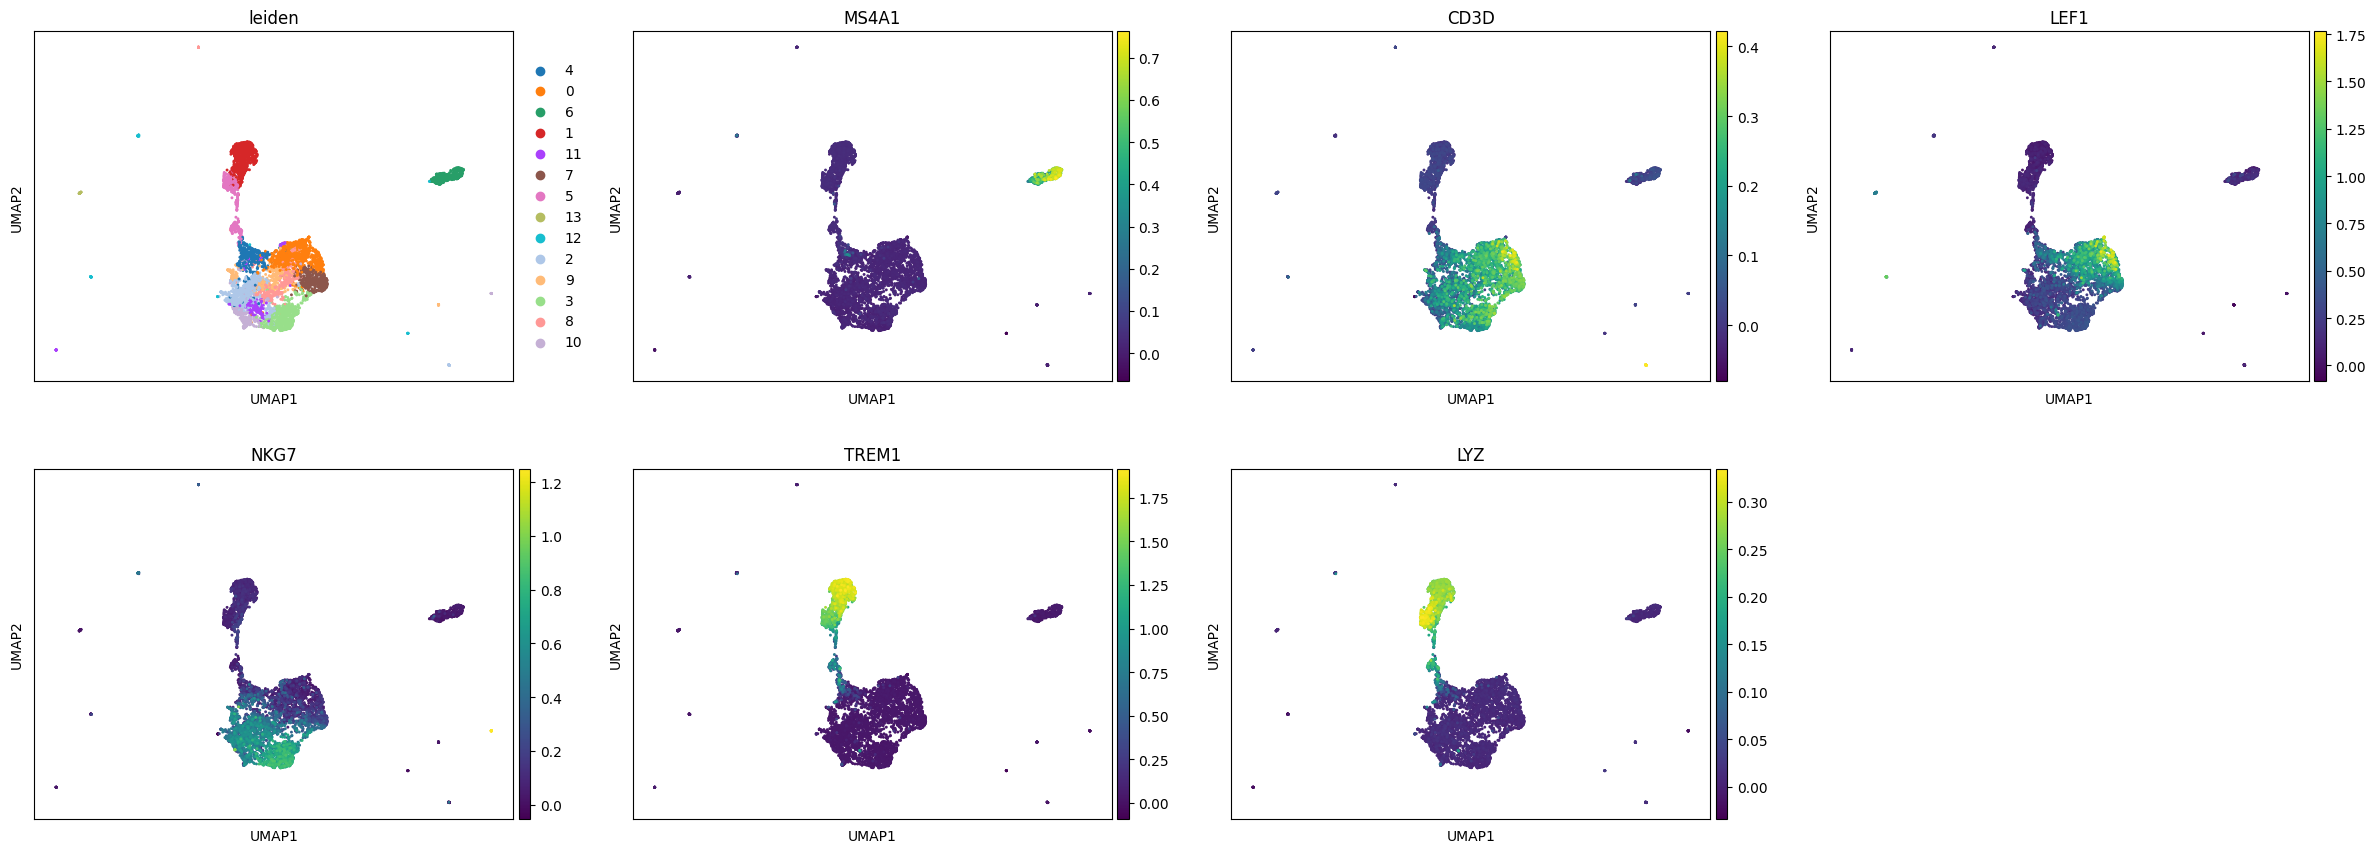

2022-11-22 13:50:06 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-11-22 13:50:07 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-11-22 13:50:07 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-11-22 13:50:07 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-11-22 13:50:07 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

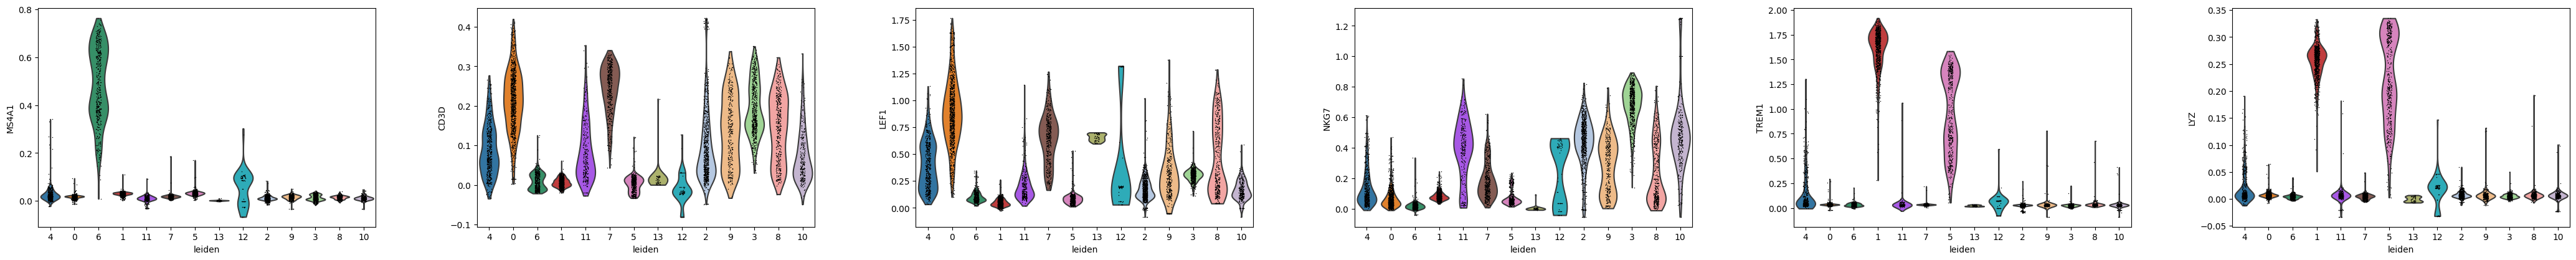

In [58]:
marker_genes = ['MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes)
sc.pl.violin(gene_matrix, marker_genes, use_raw=False, groupby='leiden')

In [61]:
data.close()
gene_matrix.write("gene_matrix.h5ad")

## Peak calling at the cluster-level

In [59]:
help(snap.tl.call_peaks)

Help on function call_peaks in module snapatac2.tools._call_peaks:

call_peaks(adata: 'AnnData | AnnDataSet', groupby: 'str | list[str]', selections: 'set[str] | None' = None, q_value: 'float' = 0.05, out_dir: 'Path | None' = None, key_added: 'str' = 'peaks', inplace: 'bool' = True) -> "'polars.DataFrame' | None"
    Call peaks using MACS2.
    
    Use the `callpeak` command in MACS2 to identify regions enriched with TN5
    insertions. The parameters passed to MACS2 are:
    "-shift -100 -extsize 200 -nomodel -callsummits -nolambda -keep-dup all"
    
    Parameters
    ----------
    adata
        The (annotated) data matrix of shape `n_obs` x `n_vars`.
        Rows correspond to cells and columns to regions.
    groupby
        Group the cells before peak calling. If a `str`, groups are obtained from
        `.obs[groupby]`.
    selections
        Call peaks for the selected groups only.
    q_value
        q_value cutoff used in MACS2.
    out_dir
        If provided, raw peak fil

In [1]:
import snapatac2 as snap

In [2]:
data = snap.read("pbmc.h5ad")

In [3]:
snap.tl.call_peaks(data, groupby="leiden")

thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: Cannot find macs2; please make sure macs2 has been installed', src/call_peaks.rs:29:11
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: called `Result::unwrap()` on an `Err` value: Cannot find macs2; please make sure macs2 has been installed